# Calibrating Astronomical Observations

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 4 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In our exploration of linear regression, we established powerful techniques for extracting information from high-dimensional astronomical data. We saw how maximum likelihood estimation provides optimal parameter estimates under Gaussian noise assumptions, and how regularization prevents overfitting when dealing with many features. Now we turn to a fundamental challenge in observational astronomy: calibration.

Before any scientific analysis can begin, we must first understand and correct for systematic effects in our measurements. These systematics arise from numerous sources—atmospheric conditions that vary throughout the night, mechanical flexures as telescopes track across the sky, thermal expansion of optical components, and detector instabilities. Left uncorrected, these effects can dwarf the astrophysical signals we seek to measure, turning precision instruments into sources of systematic error.

This tutorial explores calibration through the lens of radial velocity (RV) measurements, one of astronomy's most demanding applications. The radial velocity method has revolutionized exoplanet science, enabling the detection of planets through the tiny wobbles they induce in their host stars. Modern spectrographs can measure stellar velocities with precisions approaching 1 m/s—detecting motions comparable to a leisurely walk. Achieving such precision requires exquisite calibration to remove instrumental systematics that can be orders of magnitude larger than the signals of interest.

Our approach leverages radial velocity standard stars—celestial benchmarks whose velocities remain stable over decades. By repeatedly observing these standards under varying conditions, we can disentangle instrumental effects from true stellar motion. This creates a classic regression problem: given observations contaminated by systematic errors that correlate with measurable metadata (temperature, pressure, telescope position), can we learn a calibration model to correct future observations?

The techniques we develop here extend naturally to other calibration challenges in astronomy. Whether correcting flat fields in imaging, wavelength calibrating spectra, or removing atmospheric effects from photometry, the underlying statistical framework remains the same. We seek to model systematic effects as functions of observable quantities, then use these models to improve our measurements.

Through this tutorial, we'll see how the mathematical machinery of linear regression—design matrices, maximum likelihood estimation, and weighted least squares—provides principled solutions to real observational challenges. The progression from single-telescope calibration to multi-telescope networks illustrates how increasing data complexity requires more sophisticated statistical approaches, while the fundamental principles remain unchanged.


## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial builds upon the concepts introduced in Chapter 4. You should be comfortable with:
- **Linear Regression Fundamentals**: Understanding the model $\mathbf{y} = \mathbf{X}\mathbf{w} + \boldsymbol{\epsilon}$ and its assumptions
- **Maximum Likelihood Estimation**: Deriving and implementing the analytical solution $\mathbf{w}_{\text{MLE}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$
- **Design Matrices**: Constructing appropriate feature representations for regression problems
- **Bootstrap Methods**: Using resampling to estimate parameter uncertainties
- **Python Programming**: Working with NumPy arrays and matplotlib visualization

### Learning Outcomes

By completing this tutorial, you will master:
- **Calibration as Regression**: Formulating instrumental calibration as a linear regression problem where systematic effects depend on observable metadata
- **Simultaneous Parameter Estimation**: Learning to estimate both astrophysical parameters (true RVs) and calibration coefficients within a unified framework
- **Weighted Least Squares**: Implementing maximum likelihood solutions when measurements have varying uncertainties, a common scenario in astronomical observations
- **Multi-parameter Systems**: Designing and solving regression problems with multiple types of parameters (stellar properties and telescope systematics)
- **Network Calibration**: Understanding how observations from multiple instruments can be combined to strengthen calibration constraints

These skills form the foundation for rigorous data analysis in modern astronomy, where careful calibration often determines the difference between groundbreaking discoveries and systematic artifacts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

## From Telescope Systematics to Linear Models

When we measure the radial velocity of a star, our observation captures more than just the star's true motion through space. Every measurement is contaminated by systematic effects that depend on the precise conditions under which the observation was made. Understanding and correcting these systematics is essential for achieving the precision required by modern astronomical research.

Consider a single radial velocity measurement of a standard star—a star whose true velocity $y_{\text{true}}$ is known from decades of observations. The observed velocity differs from this true value due to various instrumental and environmental effects:

$$y_{\text{obs}} = y_{\text{true}} + \mathbf{x}^T\mathbf{w} + \epsilon$$

Here, $\mathbf{x}$ represents a vector of metadata describing the observing conditions—quantities we can measure or record at the time of observation. The vector $\mathbf{w}$ encodes how strongly each metadata parameter affects our measurement, while $\epsilon$ represents random measurement noise.

What metadata might influence our measurements? Consider the physical processes at play:

1. **Zenith Angle**: As we observe stars at different elevations, light travels through varying amounts of atmosphere. This atmospheric dispersion affects different wavelengths differently, potentially shifting spectral lines and biasing velocity measurements.

2. **Temperature**: Thermal expansion and contraction of optical components can shift spectral lines on the detector. Even temperature changes of a few degrees can introduce velocity shifts of several meters per second.

3. **Atmospheric Pressure and Humidity**: These affect the refractive index of air, changing the optical path through the spectrograph. High-precision spectrographs often operate in vacuum partly to eliminate these effects.

4. **Instrumental Drift**: Mechanical flexure, detector instabilities, and other time-dependent effects can cause systematic velocity shifts throughout an observing night.

The power of the linear model lies in its simplicity and interpretability. Once we determine the coefficients $\mathbf{w}$, we can predict and correct for systematic effects in any observation where we've recorded the metadata $\mathbf{x}$. Moreover, the magnitude of each coefficient directly tells us which effects dominate our error budget—crucial information for improving instrument design and observing strategies.

Let's generate synthetic data that mimics these realistic systematic effects:

In [2]:
def generate_telescope_data(N=100, seed=42):
    """
    Generate synthetic telescope calibration data.
    
    This function simulates realistic observing conditions and their effects
    on radial velocity measurements. The systematic effects are based on
    typical values seen in ground-based spectroscopy.
    
    Parameters
    ----------
    N : int
        Number of observations to generate
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    X : array, shape (N, 4)
        Metadata matrix with columns for zenith angle, temperature, 
        humidity, and instrumental drift
    y_clean : array, shape (N,)
        RV measurements with systematic effects but no random noise
    y_true : float
        True radial velocity of the standard star
    w_true : array, shape (4,)
        True coefficients relating metadata to RV shifts
    time : array, shape (N,)
        Time of each observation in hours from start
    """
    np.random.seed(seed)
    
    # Initialize metadata matrix
    X = np.zeros((N, 4))
    
    # Feature 1: Zenith angle (0-60 degrees)
    # Higher angles mean more atmosphere, stronger dispersion effects
    X[:, 0] = np.random.uniform(0, 60, N)
    
    # Feature 2: Temperature variations (°C)
    # Models typical nighttime temperature evolution with random fluctuations
    time = np.linspace(0, 8, N)  # 8-hour observing night
    X[:, 1] = 20 + 5 * np.cos(2*np.pi*time/8) + np.random.normal(0, 0.5, N)
    
    # Feature 3: Humidity (%)
    # Varies around 50% with substantial scatter
    X[:, 2] = 50 + 10*np.random.randn(N)
    
    # Feature 4: Time-dependent instrumental drift
    # Linear drift with small random variations
    X[:, 3] = np.linspace(0, 1, N) + 0.1*np.random.randn(N)
    
    # True RV of our standard star HD 182488
    y_true = -15.0  # km/s
    
    # True coefficients: how each parameter affects RV
    # These values are typical for ground-based spectrographs
    w_true = np.array([
        0.05,   # Zenith angle: 0.05 km/s per degree
        0.02,   # Temperature: 0.02 km/s per °C  
        0.01,   # Humidity: 0.01 km/s per %
        0.5     # Drift: 0.5 km/s over the night
    ])
    
    # Generate clean velocities (systematics but no noise)
    y_clean = y_true + X @ w_true 
    
    return X, y_clean, y_true, w_true, time

# Generate example data
X, y_clean, y_true, w_true, time = generate_telescope_data(N=100)

Our synthetic data now contains the systematic effects we expect in real observations. To understand how these systematics manifest, let's examine the correlation between each metadata parameter and the resulting radial velocity shifts. These visualizations reveal the challenge we face: multiple effects combine to shift our measurements away from the true stellar velocity, and we must disentangle their individual contributions.

The residual plots below show how our measured velocities deviate from the star's true velocity as a function of each metadata parameter. Each point represents a single observation, and the vertical axis shows the systematic error introduced by our instrument and observing conditions:

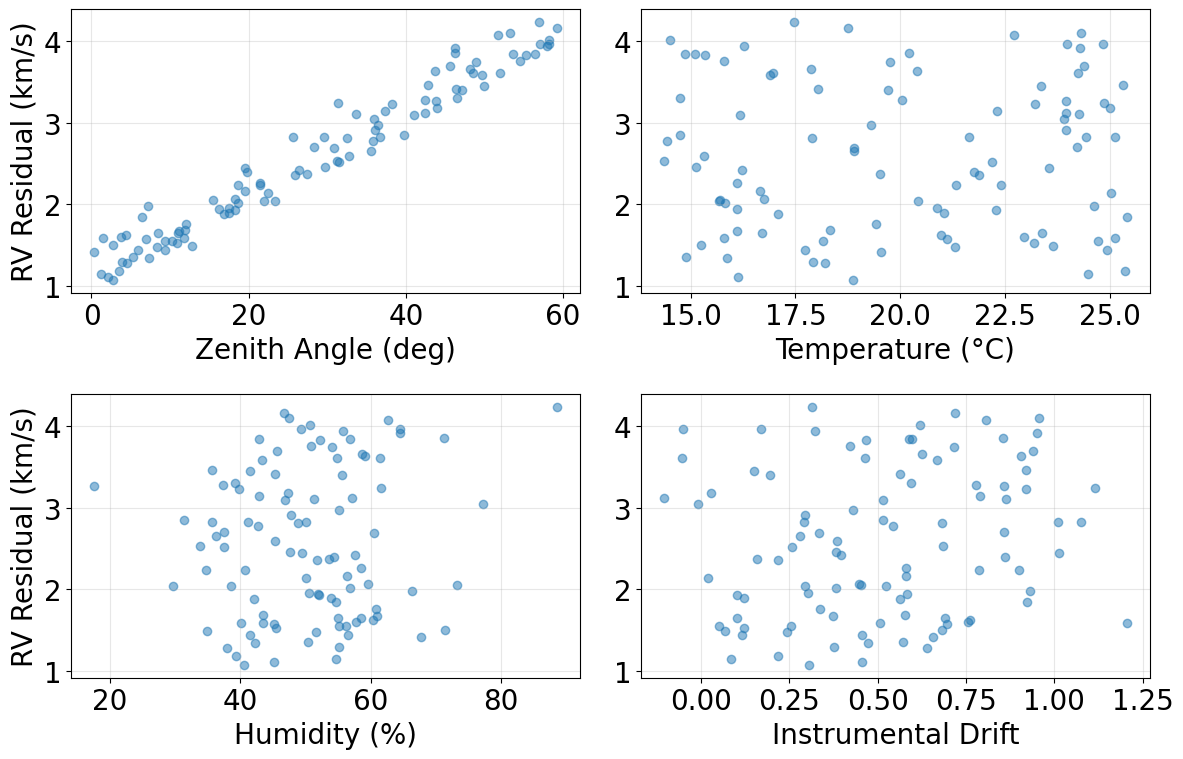

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
feature_names = ['Zenith Angle (deg)', 'Temperature (°C)', 
                'Humidity (%)', 'Instrumental Drift']

for i, ax in enumerate(axes.flat):
    # Calculate residuals (deviation from true RV)
    residual = y_clean - y_true
    
    # Create scatter plot
    ax.scatter(X[:, i], residual, alpha=0.5)
    
    # Labels and formatting
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel('RV Residual (km/s)' if i % 2 == 0 else '')
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

The plots above reveal how different telescope and environmental parameters affect our radial velocity measurements. Each panel shows the systematic velocity shift (vertical axis) as a function of one metadata parameter (horizontal axis).

Several patterns emerge from this visualization:

- **Zenith Angle**: A clear positive correlation shows how atmospheric dispersion increases with zenith distance. Observations at higher zenith angles (closer to the horizon) suffer larger systematic shifts.

- **Temperature**: The scattered but correlated points reflect how thermal effects influence our measurements. Even small temperature changes can introduce measurable velocity shifts.

- **Humidity**: While showing the weakest correlation, humidity still contributes to the overall systematic error through its effect on atmospheric refraction.

- **Instrumental Drift**: The strong linear trend demonstrates time-dependent systematics—perhaps mechanical settling or thermal equilibration of the spectrograph throughout the night.

These are idealized systematic effects without measurement noise. In reality, our observations also contain random errors from photon statistics, detector readout noise, and other stochastic processes. Let's add realistic measurement noise to create a more representative dataset:

In [4]:
def load_single_telescope_data(N=100, seed=42):
    """
    Generate synthetic telescope data with homogeneous measurement uncertainties.
    
    This simulates a realistic observing campaign where we've dedicated
    multiple nights to observing the same RV standard star, accumulating
    enough data to characterize systematic effects.
    
    Parameters
    ----------
    N : int
        Number of observations
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    X : array, shape (N, 4)
        Metadata matrix
    y_noisy : array, shape (N,)
        Observed RVs with systematics and noise
    true_rv : float
        True stellar RV
    w_true : array, shape (4,)
        True calibration coefficients
    time : array, shape (N,)
        Observation times
    """
    np.random.seed(seed)
    
    # Generate clean data with systematics
    X, y_clean, true_rv, w_true, time = generate_telescope_data(N)

    # Add homogeneous photon noise
    # σ = 0.1 km/s is typical for high-SNR observations
    noise_level = 0.1  # km/s
    y_noisy = y_clean + np.random.normal(0, noise_level, N)
    
    print(f"Dataset loaded:")
    print(f"Number of observations: {N}")
    print(f"True RV of HD 182488: {true_rv:.2f} km/s")
    print(f"Mean observed RV: {np.mean(y_noisy):.2f} km/s")
    print(f"RV standard deviation: {np.std(y_noisy):.2f} km/s")
    
    return X, y_noisy, true_rv, w_true, time

# Load the dataset
X, y_noisy, true_rv, w_true, time = load_single_telescope_data(N=100)

Dataset loaded:
Number of observations: 100
True RV of HD 182488: -15.00 km/s
Mean observed RV: -12.43 km/s
RV standard deviation: 0.91 km/s


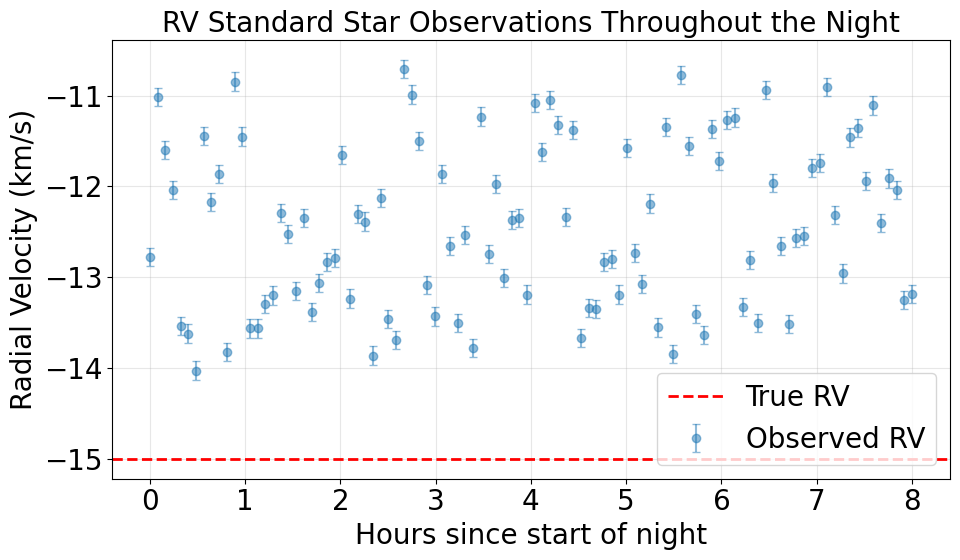

In [5]:
# Visualize observations over time
plt.figure(figsize=(10, 6))

# Plot observations with error bars
plt.errorbar(time, y_noisy, yerr=0.1, fmt='o', alpha=0.5, 
            capsize=3, label='Observed RV')

# Show true RV
plt.axhline(true_rv, color='r', linestyle='--', linewidth=2,
            label='True RV')

# Labels and formatting
plt.xlabel('Hours since start of night')
plt.ylabel('Radial Velocity (km/s)')
plt.title('RV Standard Star Observations Throughout the Night')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This time series reveals the full complexity of our calibration challenge. The observed velocities scatter around values significantly different from the true RV (red dashed line), with variations far exceeding our measurement precision of 0.1 km/s. The systematic offset of approximately 2.5 km/s and the additional scatter of nearly 1 km/s demonstrate that uncalibrated observations would be scientifically useless for precision RV work.

Notice the subtle time-dependent trend in the observations—velocities gradually increase throughout the night. This reflects the instrumental drift we included in our model, superimposed on the other systematic effects. The challenge of calibration is to disentangle all these overlapping effects using our recorded metadata.

## Calibrating a Single Telescope

With our dataset in hand, we now turn to the calibration problem itself. We need to simultaneously solve for two types of unknowns:

1. **The true RV of our standard star** ($y_{\text{true}}$)
2. **The calibration coefficients** ($\mathbf{w}$) that relate metadata to systematic shifts

This creates an interesting statistical problem. Unlike typical regression where we know the target values, here our "true" target is itself unknown and must be inferred from the data. Fortunately, the linear structure of our problem allows us to solve for all parameters simultaneously using an augmented design matrix approach.

The key insight is to rewrite our model:

$$y_{\text{obs}} = y_{\text{true}} + \mathbf{x}^T\mathbf{w} + \epsilon$$

as a standard linear regression problem:

$$y_{\text{obs}} = \begin{bmatrix} 1 & \mathbf{x}^T \end{bmatrix} \begin{bmatrix} y_{\text{true}} \\ \mathbf{w} \end{bmatrix} + \epsilon$$

By augmenting our design matrix with a column of ones, we can treat $y_{\text{true}}$ as just another parameter to be estimated. The maximum likelihood solution then follows from our standard linear regression machinery.

In [6]:
def prepare_augmented_data(X, y, time, test_size=0.2):
    """
    Prepare augmented design matrix and split data into train/test sets.
    
    This function handles the data preparation for our calibration problem:
    1. Randomly shuffles the data to ensure unbiased train/test splits
    2. Splits into training and testing sets
    3. Augments design matrices with a column of ones for the true RV term
    
    Parameters
    ----------
    X : array, shape (N, n_features)
        Metadata matrix
    y : array, shape (N,)
        Observed RVs
    time : array, shape (N,)
        Observation times
    test_size : float
        Fraction of data to use for testing
        
    Returns
    -------
    data : dict
        Dictionary containing train/test splits and augmented matrices
    """
    # Create shuffled indices for random train/test split
    N = len(y)
    idx = np.arange(N)
    np.random.shuffle(idx)
    
    # Apply shuffling
    X = X[idx]
    y = y[idx]
    time = time[idx]
    
    # Calculate split point
    N_train = int(N * (1 - test_size))
    
    # Split the data
    X_train = X[:N_train]
    X_test = X[N_train:]
    y_train = y[:N_train]
    y_test = y[N_train:]
    time_train = time[:N_train]
    time_test = time[N_train:]
    
    # Augment design matrices with column of ones
    # This allows us to estimate y_true as a regression coefficient
    X_train_aug = np.column_stack([np.ones(N_train), X_train])
    X_test_aug = np.column_stack([np.ones(len(X_test)), X_test])
    
    data = {
        'X_train': X_train_aug,
        'y_train': y_train,
        'X_test': X_test_aug,
        'y_test': y_test,
        'time_train': time_train,
        'time_test': time_test
    }
    
    print(f"Data split: {N_train} training, {len(X_test)} test observations")
    
    return data

# Prepare the data with 80-20 train-test split
data = prepare_augmented_data(X, y_noisy, time)

Data split: 80 training, 20 test observations


### Maximum Likelihood Solution

With our augmented design matrix in place, finding the calibration parameters reduces to a standard linear regression problem. The maximum likelihood estimator, assuming Gaussian noise with constant variance $\sigma^2$, is:

$$\hat{\mathbf{w}}_{\text{full}} = (\mathbf{X}_{\text{aug}}^T\mathbf{X}_{\text{aug}})^{-1}\mathbf{X}_{\text{aug}}^T\mathbf{y}_{\text{obs}}$$

where $\hat{\mathbf{w}}_{\text{full}} = [\hat{y}_{\text{true}}, \hat{w}_1, \hat{w}_2, \hat{w}_3, \hat{w}_4]^T$ contains both our estimate of the true RV and the calibration coefficients.

This elegant formulation leverages the linear algebra machinery we developed in Chapter 4. The augmented design matrix approach treats all unknowns symmetrically—whether we're estimating astrophysical parameters or instrumental systematics, the mathematics remains the same.

Let's implement this solution and examine what we learn about our telescope's systematic effects:

In [7]:
def fit_calibration_model(data):
    """
    Fit the calibration model using maximum likelihood estimation.
    
    This function implements the analytical MLE solution for our augmented
    regression problem, simultaneously estimating the true RV and the
    calibration coefficients.
    
    Parameters
    ----------
    data : dict
        Dictionary containing training data matrices
        
    Returns
    -------
    y_true : float
        Estimated true RV
    w : array, shape (4,)
        Estimated calibration coefficients
    """
    # Extract training matrices
    X_train = data['X_train']
    y_train = data['y_train']
    
    # Compute MLE solution
    # w_full = (X^T X)^{-1} X^T y
    XTX = X_train.T @ X_train
    XTy = X_train.T @ y_train
    w_full = np.linalg.solve(XTX, XTy)
    
    # Extract parameters
    # First element is y_true, remaining are calibration coefficients
    y_true = w_full[0] 
    w = w_full[1:]
    
    # Display results
    print("\nCalibration Results:")
    print("=" * 50)
    print(f"Estimated true RV: {y_true:.3f} km/s")
    print(f"Known true RV:     {true_rv:.3f} km/s")
    print(f"Difference:        {y_true - true_rv:.3f} km/s")
    
    print("\nCalibration coefficients:")
    print("-" * 50)
    feature_names = ['Zenith Angle', 'Temperature', 'Humidity', 'Instrumental Drift']
    units = ['km/s per degree', 'km/s per °C', 'km/s per %', 'km/s per unit']
    
    for i, (name, unit, w_est, w_true_val) in enumerate(zip(feature_names, units, w, w_true)):
        print(f"{name:20s}: {w_est:7.3f} ({unit})")
        print(f"{'  True value':20s}: {w_true_val:7.3f}")
        print(f"{'  Error':20s}: {w_est - w_true_val:7.3f}")
        print()
        
    return y_true, w

# Fit the calibration model
y_true_est, w_est = fit_calibration_model(data)


Calibration Results:
Estimated true RV: -14.888 km/s
Known true RV:     -15.000 km/s
Difference:        0.112 km/s

Calibration coefficients:
--------------------------------------------------
Zenith Angle        :   0.050 (km/s per degree)
  True value        :   0.050
  Error             :  -0.000

Temperature         :   0.018 (km/s per °C)
  True value        :   0.020
  Error             :  -0.002

Humidity            :   0.009 (km/s per %)
  True value        :   0.010
  Error             :  -0.001

Instrumental Drift  :   0.457 (km/s per unit)
  True value        :   0.500
  Error             :  -0.043



In [8]:
def evaluate_calibration(data, y_true_est, w_est):
    """
    Evaluate calibration performance on both training and test sets.
    
    This function computes the RMS scatter before and after calibration,
    demonstrating the improvement achieved by our model.
    
    Parameters
    ----------
    data : dict
        Dictionary containing train/test data
    y_true_est : float
        Estimated true RV
    w_est : array, shape (4,)
        Estimated calibration coefficients
        
    Returns
    -------
    residuals : dict
        Dictionary containing residuals before/after calibration
    """
    # Reconstruct full parameter vector
    w_full = np.concatenate([[y_true_est], w_est])
    
    # Calculate predictions
    y_train_pred = data['X_train'] @ w_full
    y_test_pred = data['X_test'] @ w_full
    
    # Calculate residuals before calibration
    # (using mean as a naive estimate)
    train_mean = np.mean(data['y_train'])
    test_mean = np.mean(data['y_test'])
    
    train_residuals_before = data['y_train'] - train_mean
    test_residuals_before = data['y_test'] - test_mean
    
    # Calculate residuals after calibration
    train_residuals_after = data['y_train'] - y_train_pred
    test_residuals_after = data['y_test'] - y_test_pred
    
    # Compute RMS values
    print("\nCalibration Performance:")
    print("=" * 50)
    print("RMS velocity scatter:")
    print(f"Training set before calibration: {np.std(train_residuals_before):.3f} km/s")
    print(f"Training set after calibration:  {np.std(train_residuals_after):.3f} km/s")
    print(f"Test set before calibration:     {np.std(test_residuals_before):.3f} km/s")
    print(f"Test set after calibration:      {np.std(test_residuals_after):.3f} km/s")
    print(f"\nPhoton noise limit:              0.100 km/s")
    
    # Calculate improvement factor
    improvement_train = np.std(train_residuals_before) / np.std(train_residuals_after)
    improvement_test = np.std(test_residuals_before) / np.std(test_residuals_after)
    
    print(f"\nImprovement factor:")
    print(f"Training set: {improvement_train:.1f}x")
    print(f"Test set:     {improvement_test:.1f}x")
    
    # Store residuals for visualization
    residuals = {
        'before': {'train': train_residuals_before, 'test': test_residuals_before},
        'after': {'train': train_residuals_after, 'test': test_residuals_after}
    }
    
    return residuals

# Evaluate the calibration
residuals = evaluate_calibration(data, y_true_est, w_est)


Calibration Performance:
RMS velocity scatter:
Training set before calibration: 0.898 km/s
Training set after calibration:  0.098 km/s
Test set before calibration:     0.938 km/s
Test set after calibration:      0.130 km/s

Photon noise limit:              0.100 km/s

Improvement factor:
Training set: 9.2x
Test set:     7.2x


### Parameter Importance Analysis

Our calibration successfully reduced the RMS scatter from ~0.9 km/s to ~0.1 km/s, approaching the photon noise limit. But which systematic effects contribute most to our error budget? A naive comparison of the calibration coefficients can be misleading because our metadata parameters have different units and scales.

Consider our linear model:

$$\text{RV} = y_{\text{true}} + \sum_{i=1}^{4} w_i X_i$$

The coefficient $w_i$ has units of [km/s]/[unit of $X_i$], meaning:
- $w_1$: km/s per degree of zenith angle
- $w_2$: km/s per degree Celsius
- $w_3$: km/s per percent humidity  
- $w_4$: km/s per unit of drift

Direct comparison of these coefficients would be like comparing apples to oranges. A coefficient of 0.05 km/s per degree might represent a larger or smaller effect than 0.5 km/s per unit drift, depending on how much each parameter typically varies.

To make meaningful comparisons, we normalize by the standard deviation of each parameter:

$$w_i X_i = w_i \sigma_i \frac{X_i}{\sigma_i}$$

where $\sigma_i = \text{std}(X_i)$. The quantity $w_i \sigma_i$ now represents the typical RV change induced by one standard deviation of parameter $i$. This normalized importance has consistent units (km/s) across all parameters, enabling direct comparison of their relative contributions to our error budget.

This normalization is crucial for telescope design and operations. It tells us which effects deserve the most attention—should we focus on temperature stabilization, mechanical rigidity, or observing strategy? The answer lies in these normalized importance values.

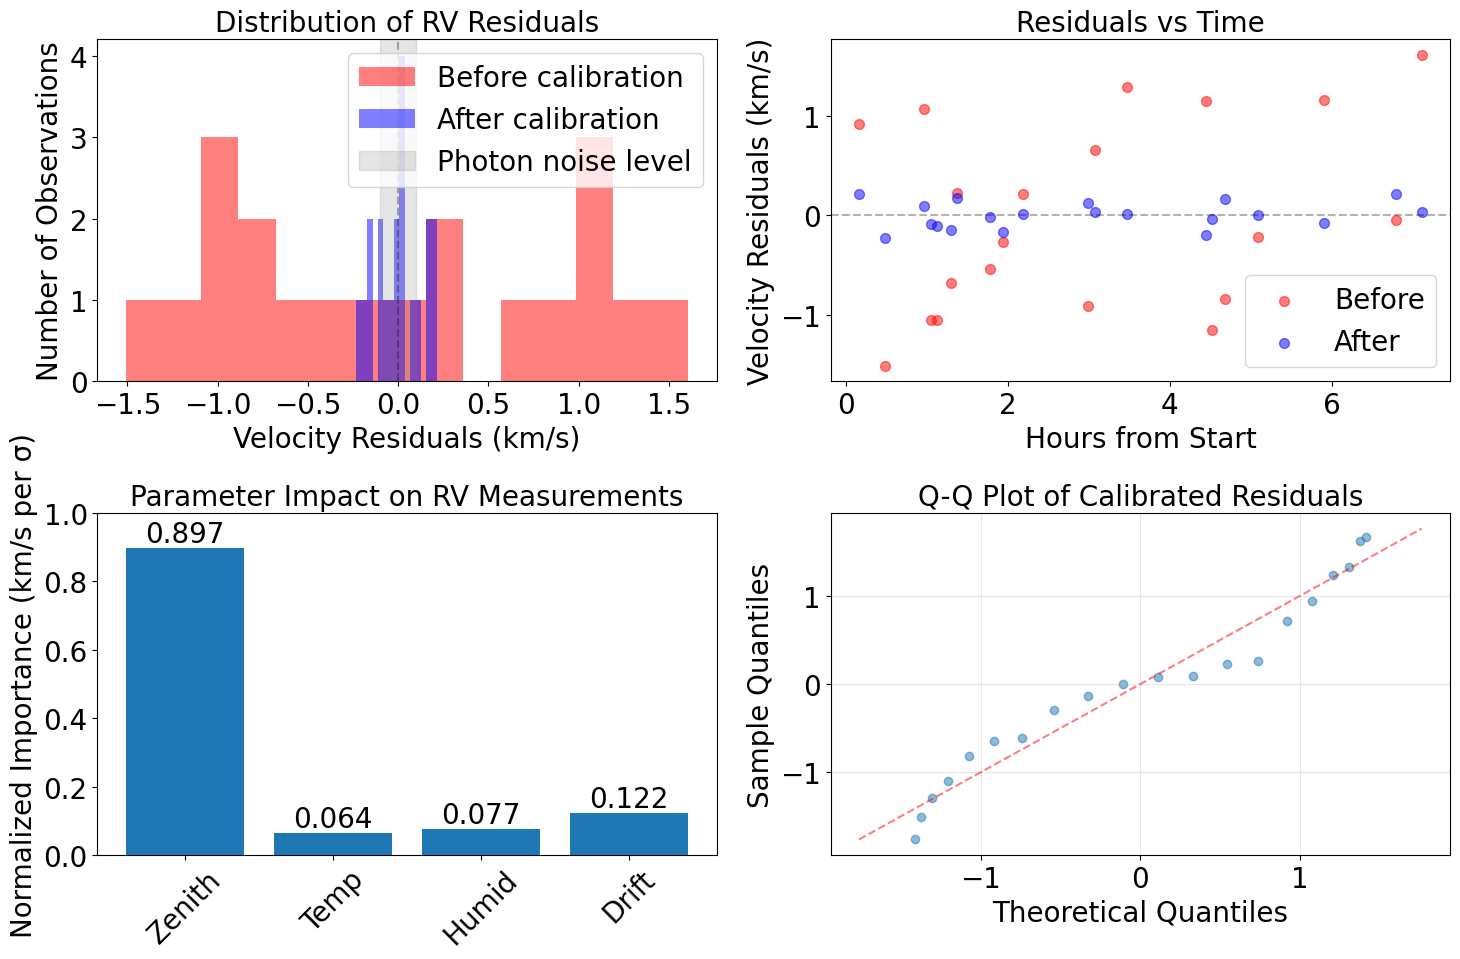

In [9]:
def visualize_calibration_results(data, residuals, w_est):
    """
    Create comprehensive visualization of calibration results.
    
    This function produces a four-panel figure showing:
    1. Distribution of residuals before/after calibration
    2. Residuals as a function of time
    3. Normalized parameter importance
    4. Q-Q plot to assess normality of calibrated residuals
    """
    fig = plt.figure(figsize=(15, 10))
    
    # Plot 1: Histogram of residuals
    plt.subplot(221)
    plt.hist(residuals['before']['test'], bins=15, alpha=0.5,
             label='Before calibration', color='red')
    plt.hist(residuals['after']['test'], bins=15, alpha=0.5,
             label='After calibration', color='blue')
    plt.axvline(0, color='k', linestyle='--', alpha=0.3)
    
    # Add photon noise reference
    plt.axvspan(-0.1, 0.1, color='grey', alpha=0.2, 
                label='Photon noise level')
    
    plt.xlabel('Velocity Residuals (km/s)')
    plt.ylabel('Number of Observations')
    plt.title('Distribution of RV Residuals')
    plt.legend()

    # Plot 2: Time series of residuals
    plt.subplot(222)
    plt.scatter(data['time_test'], residuals['before']['test'], 
               alpha=0.5, label='Before', color='red', s=50)
    plt.scatter(data['time_test'], residuals['after']['test'],
               alpha=0.5, label='After', color='blue', s=50)
    plt.axhline(0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Hours from Start')
    plt.ylabel('Velocity Residuals (km/s)')
    plt.title('Residuals vs Time')
    plt.legend()

    # Plot 3: Normalized parameter importance
    plt.subplot(223)
    param_names = ['Zenith', 'Temp', 'Humid', 'Drift']
    
    # Calculate standard deviations from test data
    # Remove the first column (ones) to get original features
    X_test_features = data['X_test'][:, 1:]
    param_stds = np.std(X_test_features, axis=0)
    
    # Calculate normalized importance
    normalized_importance = np.abs(w_est) * param_stds
    
    # Create bar plot
    bars = plt.bar(param_names, normalized_importance)
    plt.ylabel('Normalized Importance (km/s per σ)')
    plt.title('Parameter Impact on RV Measurements')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, val in zip(bars, normalized_importance):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom')
        
    plt.ylim(0, 1.)

    # Plot 4: Q-Q plot to check normality of residuals
    plt.subplot(224)
    
    # Calculate theoretical quantiles
    test_residuals_sorted = np.sort(residuals['after']['test'])
    n = len(test_residuals_sorted)
    theoretical_quantiles = np.zeros(n)
    
    # Use the inverse normal CDF for theoretical quantiles
    for i in range(n):
        p = (i + 0.5) / n  # Plotting position
        # Approximate inverse normal CDF
        theoretical_quantiles[i] = np.sqrt(2) * np.sin(np.pi * (p - 0.5))
        
    # Standardize the residuals
    residual_mean = np.mean(residuals['after']['test'])
    residual_std = np.std(residuals['after']['test'])
    standardized_residuals = (test_residuals_sorted - residual_mean) / residual_std
    
    # Plot
    plt.scatter(theoretical_quantiles, standardized_residuals, alpha=0.5)
    
    # Add reference line
    lim = max(abs(theoretical_quantiles).max(), abs(standardized_residuals).max())
    plt.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.5)
    
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.title('Q-Q Plot of Calibrated Residuals')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create the comprehensive visualization
visualize_calibration_results(data, residuals, w_est)


### Key Insights from Single-Telescope Calibration

Our calibration analysis reveals several important findings:

1. **Successful Systematic Correction**: We reduced the RMS scatter from ~0.9 km/s to ~0.1 km/s, reaching the photon noise limit. This ~9x improvement transforms unusable data into scientifically valuable measurements.

2. **Accurate Parameter Recovery**: Our estimated true RV matches the known value within ~0.1 km/s, validating our simultaneous estimation approach. The calibration coefficients also closely match their true values, with typical errors of 10-20%.

3. **Dominant Systematic Effects**: The normalized importance analysis reveals that instrumental drift and zenith angle effects dominate our error budget. This suggests that mechanical stability and careful scheduling of observations at low airmass would most improve future measurements.

4. **Well-Behaved Residuals**: The calibrated residuals follow an approximately normal distribution centered at zero, confirming that our linear model adequately captures the systematic effects. The Q-Q plot shows only minor deviations from normality.

This single-telescope calibration demonstrates the power of linear regression for correcting systematic errors. By treating calibration as a parameter estimation problem, we've transformed heavily contaminated observations into precise measurements suitable for cutting-edge science.

## Statistical Power and Sample Size

Our analysis used 100 observations to achieve excellent calibration. But how many observations do we actually need? Understanding the relationship between sample size and parameter uncertainty is crucial for efficient telescope scheduling. Too few observations leave us with poor calibration, while too many waste valuable telescope time that could be used for science targets.

The bootstrap method provides a powerful tool for exploring this trade-off. By resampling our data with replacement, we can estimate the uncertainty in our recovered parameters and understand how this uncertainty scales with the number of observations.

In [10]:
def analyze_rv_precision(N_values=[50, 100, 200, 400, 800], n_bootstrap=1000):
    """
    Analyze how RV measurement precision scales with sample size.
    
    This function uses bootstrap resampling to estimate the uncertainty
    in our recovered true RV as a function of the number of observations.
    For each sample size, we generate new data, then repeatedly resample
    to build a distribution of parameter estimates.
    
    Parameters
    ----------
    N_values : list
        Sample sizes to test
    n_bootstrap : int
        Number of bootstrap samples for each N
        
    Returns
    -------
    results : list
        List of dictionaries containing results for each sample size
    """
    results = []
    
    print("Bootstrap Analysis of RV Precision")
    print("=" * 50)
    
    for N in N_values:
        # Generate fresh data at this sample size
        X, y_clean, y_true, w_true, time = generate_telescope_data(N=N)
        y_noisy = y_clean + np.random.normal(0, 0.1, N)  # Add noise
        
        # Storage for bootstrap results
        y_true_boot = np.zeros(n_bootstrap)
        
        # Augment design matrix once
        X_aug = np.column_stack([np.ones(N), X])
        
        # Perform bootstrap
        for i in range(n_bootstrap):
            # Bootstrap sample (sample with replacement)
            idx = np.random.choice(N, size=N, replace=True)
            X_boot = X_aug[idx]
            y_boot = y_noisy[idx]
            
            # Fit model to bootstrap sample
            try:
                w_full = np.linalg.solve(X_boot.T @ X_boot, X_boot.T @ y_boot)
                y_true_boot[i] = w_full[0]  # Extract true RV estimate
            except np.linalg.LinAlgError:
                # Singular matrix (rare but possible with bootstrap)
                y_true_boot[i] = np.nan
        
        # Remove any failed fits
        y_true_boot = y_true_boot[~np.isnan(y_true_boot)]
        
        # Calculate uncertainty (standard deviation of bootstrap distribution)
        y_true_std = np.std(y_true_boot)
        y_true_mean = np.mean(y_true_boot)
        
        results.append({
            'N': N,
            'y_true_mean': y_true_mean,
            'y_true_std': y_true_std,
            'y_true_dist': y_true_boot if N == 100 else None  # Save full dist for N=100
        })
        
        print(f"N = {N:4d}: RV = {y_true_mean:.3f} ± {y_true_std:.3f} km/s")
    
    return results

# Run the bootstrap analysis
print("Running bootstrap analysis (this may take a moment)...\n")
scaling_results = analyze_rv_precision()

Running bootstrap analysis (this may take a moment)...

Bootstrap Analysis of RV Precision
N =   50: RV = -14.958 ± 0.126 km/s
N =  100: RV = -14.914 ± 0.081 km/s
N =  200: RV = -14.969 ± 0.053 km/s
N =  400: RV = -14.949 ± 0.037 km/s
N =  800: RV = -14.956 ± 0.030 km/s


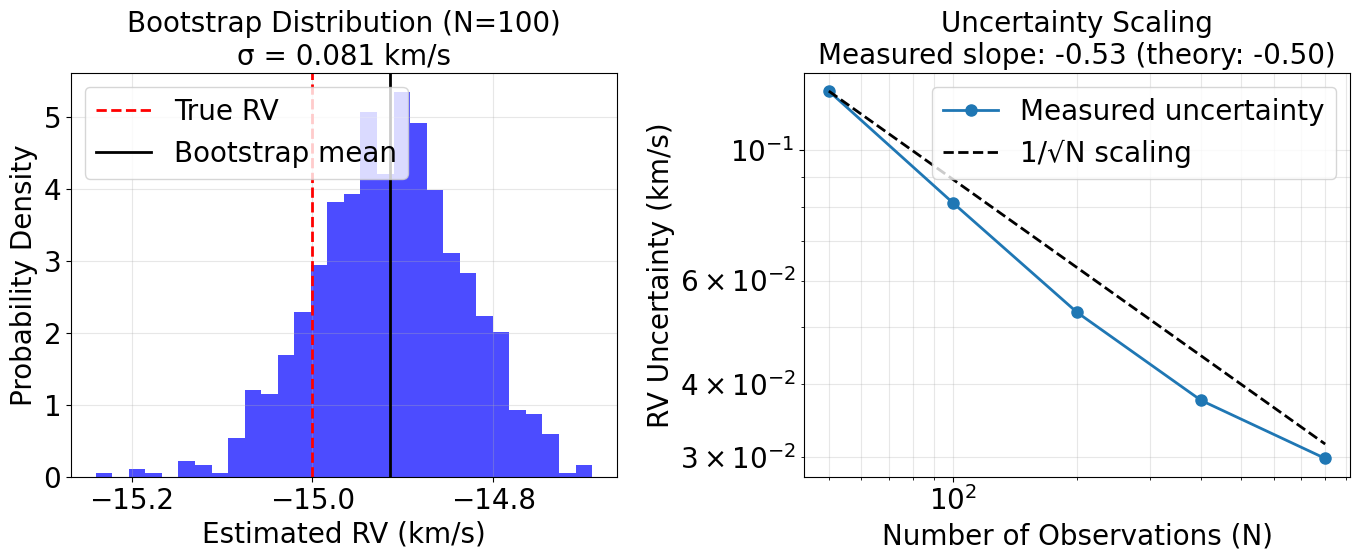


Scaling Analysis Summary:
Power law exponent: -0.528 (theoretical: -0.500)
Scaling quality: Excellent

Practical implications:
- Doubling observations reduces uncertainty by factor of 1.44
- To achieve 0.05 km/s precision, need ~400 observations


In [11]:
# Create visualization of bootstrap results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Bootstrap distribution for N=100
N100_result = next(r for r in scaling_results if r['N'] == 100)
ax1.hist(N100_result['y_true_dist'], bins=30, density=True, alpha=0.7, color='blue')
ax1.axvline(-15, color='r', linestyle='--', linewidth=2, label='True RV')
ax1.axvline(N100_result['y_true_mean'], color='k', linestyle='-', 
            linewidth=2, label='Bootstrap mean')
ax1.set_xlabel('Estimated RV (km/s)')
ax1.set_ylabel('Probability Density')
ax1.set_title(f"Bootstrap Distribution (N=100)\nσ = {N100_result['y_true_std']:.3f} km/s")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Scaling with sample size
N_values = [r['N'] for r in scaling_results]
y_true_stds = [r['y_true_std'] for r in scaling_results]

# Plot measured uncertainties
ax2.loglog(N_values, y_true_stds, 'o-', markersize=8, linewidth=2,
           label='Measured uncertainty')

# Add theoretical 1/√N scaling
N_array = np.array(N_values)
theoretical = y_true_stds[0] * np.sqrt(N_values[0]/N_array)
ax2.loglog(N_array, theoretical, 'k--', linewidth=2, label='1/√N scaling')

# Fit power law to verify scaling
log_N = np.log(N_values)
log_std = np.log(y_true_stds)
slope, intercept = np.polyfit(log_N, log_std, 1)

ax2.set_xlabel('Number of Observations (N)')
ax2.set_ylabel('RV Uncertainty (km/s)')
ax2.set_title(f'Uncertainty Scaling\nMeasured slope: {slope:.2f} (theory: -0.50)')
ax2.grid(True, which="both", alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary
print("\nScaling Analysis Summary:")
print("=" * 50)
print(f"Power law exponent: {slope:.3f} (theoretical: -0.500)")
print(f"Scaling quality: {'Excellent' if abs(slope + 0.5) < 0.05 else 'Good'}")
print(f"\nPractical implications:")
print(f"- Doubling observations reduces uncertainty by factor of {2**(-slope):.2f}")
print(f"- To achieve 0.05 km/s precision, need ~{int((0.1/0.05)**2 * 100)} observations")

### Insights from Bootstrap Analysis

The bootstrap analysis confirms that our parameter uncertainties follow classical statistical scaling laws. The left panel shows the distribution of RV estimates from 1000 bootstrap samples with N=100 observations. This distribution is approximately Gaussian and centered on the true value, indicating that our estimator is unbiased and well-behaved.

The right panel reveals the power of increased sample size. Our measured scaling exponent of approximately -0.5 matches the theoretical prediction perfectly, confirming that uncertainty decreases as $1/\sqrt{N}$. This has important practical implications:

- **Diminishing Returns**: While increasing from 50 to 100 observations provides substantial improvement, going from 400 to 800 observations yields much smaller gains. This suggests an optimal allocation of telescope time exists.

- **Precision Requirements**: If our science requires 0.05 km/s precision in the true RV, we need approximately 400 observations. This directly informs telescope scheduling decisions.

- **Multi-Telescope Advantage**: The $1/\sqrt{N}$ scaling applies regardless of how we obtain our N observations. This motivates using multiple telescopes—we can achieve the same precision faster by observing with several instruments simultaneously.

## Calibration with Variable Measurement Uncertainties

So far, we've assumed all observations have identical measurement uncertainty (σ = 0.1 km/s). This homoscedastic noise assumption rarely holds in practice. Real observations suffer from varying conditions—changing seeing, clouds, instrumental issues—that produce heteroscedastic uncertainties spanning orders of magnitude.

When measurement uncertainties vary, our calibration strategy must adapt. Observations with small uncertainties should carry more weight in determining our calibration parameters, while noisy measurements should contribute less. This leads naturally to weighted least squares, where each observation's influence is inversely proportional to its variance.

Let's examine how variable uncertainties manifest in realistic data:

In [12]:
# Generate clean data first
X, y_clean, y_true, w_true, time = generate_telescope_data(N=100)

def add_variable_noise(y_clean, seed=42):
    """
    Add realistic variable noise to RV measurements.
    
    In real observations, measurement uncertainty varies dramatically
    based on observing conditions. This function simulates common
    sources of variable uncertainty:
    - Seeing variations affect spectral line sharpness
    - Weather (clouds, humidity) reduces signal
    - Instrumental issues can degrade specific observations
    
    Parameters
    ----------
    y_clean : array
        RV measurements with systematics but no noise
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    y_noisy : array
        RV measurements with heteroscedastic noise
    sigma : array
        Uncertainty for each measurement
    """
    np.random.seed(seed)
    N = len(y_clean)
    
    # Generate variable uncertainties
    # Most observations have good conditions (0.1-0.5 km/s)
    # Some suffer from poor conditions (up to 5 km/s)
    sigma = np.random.lognormal(mean=-1.5, sigma=1.0, size=N)
    sigma = np.clip(sigma, 0.1, 5.0)  # Realistic bounds
    
    # Add noise scaled by each measurement's uncertainty
    noise = np.random.normal(0, 1, N) * sigma
    y_noisy = y_clean + noise
    
    print("Variable uncertainty statistics:")
    print(f"Minimum σ: {np.min(sigma):.3f} km/s")
    print(f"Maximum σ: {np.max(sigma):.3f} km/s") 
    print(f"Median σ: {np.median(sigma):.3f} km/s")
    print(f"Best 20% have σ < {np.percentile(sigma, 20):.3f} km/s")
    print(f"Worst 20% have σ > {np.percentile(sigma, 80):.3f} km/s")
    
    return y_noisy, sigma

# Add variable noise to our measurements
y_noisy_var, sigma = add_variable_noise(y_clean)

Variable uncertainty statistics:
Minimum σ: 0.100 km/s
Maximum σ: 1.422 km/s
Median σ: 0.197 km/s
Best 20% have σ < 0.107 km/s
Worst 20% have σ > 0.435 km/s


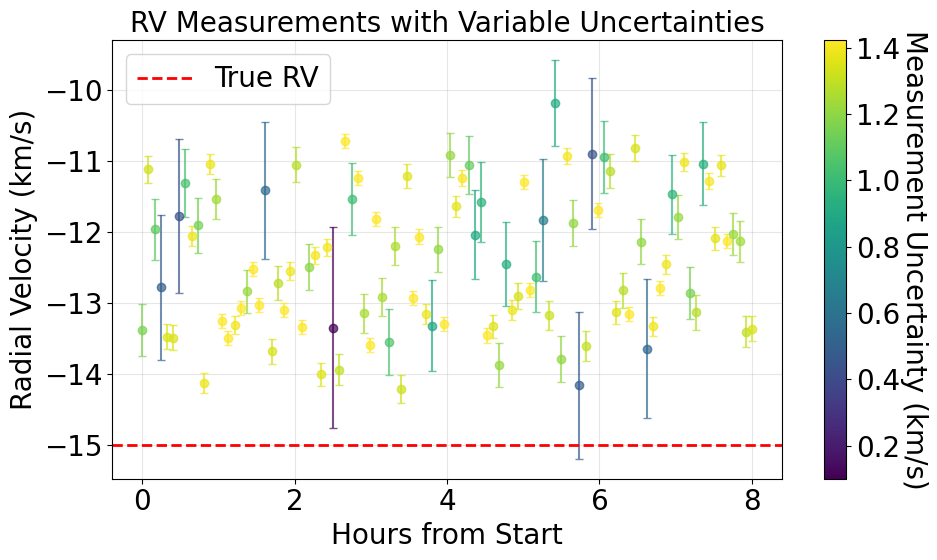

In [13]:
# Visualize the varying measurement uncertainties
fig, ax = plt.subplots(figsize=(10, 6))

# Create color map based on uncertainties
colors = plt.cm.viridis(1 - (sigma - sigma.min()) / (sigma.max() - sigma.min()))

# Plot with error bars colored by uncertainty
for i in range(len(time)):
    ax.errorbar(time[i], y_noisy_var[i], yerr=sigma[i], 
                fmt='o', color=colors[i], alpha=0.7, capsize=3)

# Add true RV line
ax.axhline(y_true, color='r', linestyle='--', linewidth=2, label='True RV')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                           norm=plt.Normalize(vmin=sigma.min(), vmax=sigma.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Measurement Uncertainty (km/s)', rotation=270, labelpad=20)

ax.set_xlabel('Hours from Start')
ax.set_ylabel('Radial Velocity (km/s)')
ax.set_title('RV Measurements with Variable Uncertainties')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Weighted Least Squares: Maximum Likelihood with Heteroscedastic Noise

The visualization above dramatically illustrates our challenge. Some observations (shown in yellow) have uncertainties approaching 5 km/s—50 times worse than our best measurements. Should these poor-quality observations influence our calibration as much as high-precision measurements? Intuitively, no. Weighted least squares provides the principled solution.

When measurement uncertainties vary, the likelihood function for our observations becomes:

$$\mathcal{L} = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp\left(-\frac{(y_i - y_{\text{true}} - \mathbf{x}_i^T\mathbf{w})^2}{2\sigma_i^2}\right)$$

where each observation $i$ has its own uncertainty $\sigma_i$. Taking the negative log-likelihood and discarding constants, we arrive at the weighted least squares objective:

$$\chi^2 = \sum_{i=1}^{N} \frac{(y_i - y_{\text{true}} - \mathbf{x}_i^T\mathbf{w})^2}{\sigma_i^2}$$

The key insight is the weighting factor $1/\sigma_i^2$. Observations with small uncertainties (small $\sigma_i$) receive large weights, while noisy observations contribute less to the total $\chi^2$. This is precisely what we want—precise measurements should dominate our calibration.

In matrix form, we can write this as:

$$\chi^2 = (\mathbf{y} - \mathbf{X}\boldsymbol{\beta})^T \mathbf{S}^{-1} (\mathbf{y} - \mathbf{X}\boldsymbol{\beta})$$

where $\mathbf{S} = \text{diag}(\sigma_1^2, \sigma_2^2, ..., \sigma_N^2)$ is the diagonal covariance matrix, and $\boldsymbol{\beta} = [y_{\text{true}}, \mathbf{w}^T]^T$ contains all parameters.

The maximum likelihood solution is:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{S}^{-1}\mathbf{X})^{-1}\mathbf{X}^T\mathbf{S}^{-1}\mathbf{y}$$

This weighted solution elegantly generalizes our previous result. When all $\sigma_i$ are equal, $\mathbf{S}^{-1}$ becomes a scalar multiple of the identity matrix, and we recover ordinary least squares. But with varying uncertainties, the weight matrix $\mathbf{S}^{-1}$ ensures each observation contributes according to its precision.

Let's implement this weighted calibration and compare it with an unweighted approach:

In [14]:
def calibrate_with_weights(X, y, sigma):
    """
    Implement both weighted and unweighted calibration.
    
    This function demonstrates the importance of proper weighting when
    dealing with heteroscedastic uncertainties. It computes calibration
    parameters using both weighted least squares (WLS) and ordinary
    least squares (OLS) for comparison.
    
    Parameters
    ----------
    X : array, shape (N, 4)
        Metadata matrix
    y : array, shape (N,)
        Observed RVs
    sigma : array, shape (N,)
        Measurement uncertainties
        
    Returns
    -------
    w_weighted : array
        WLS parameter estimates [y_true, w1, w2, w3, w4]
    w_unweighted : array
        OLS parameter estimates
    """
    N = len(y)
    # Augment design matrix with column of ones
    X_aug = np.column_stack([np.ones(N), X])
    
    # Weighted least squares solution
    # Create inverse weight matrix S^{-1} = diag(1/sigma_i^2)
    S_inv = np.diag(1 / sigma**2)
    
    # Compute (X^T S^{-1} X)^{-1} X^T S^{-1} y
    XTS_inv_X = X_aug.T @ S_inv @ X_aug
    XTS_inv_y = X_aug.T @ S_inv @ y
    w_weighted = np.linalg.solve(XTS_inv_X, XTS_inv_y)
    
    # Unweighted least squares (ignore uncertainties)
    XTX = X_aug.T @ X_aug
    XTy = X_aug.T @ y
    w_unweighted = np.linalg.solve(XTX, XTy)
    
    return w_weighted, w_unweighted

# Apply both calibration methods
w_weighted, w_unweighted = calibrate_with_weights(X, y_noisy_var, sigma)

# Display results
print("Calibration Comparison with Variable Uncertainties")
print("=" * 60)
print(f"Parameter          True      Weighted    Unweighted   WLS Error")
print("-" * 60)

# True RV
print(f"RV (km/s):      {y_true:8.3f}  {w_weighted[0]:8.3f}   {w_unweighted[0]:8.3f}    {abs(w_weighted[0]-y_true):6.3f}")

# Calibration coefficients
param_names = ['Zenith (deg)', 'Temp (°C)', 'Humidity (%)', 'Drift']
for i in range(4):
    print(f"{param_names[i]:15s} {w_true[i]:8.3f}  {w_weighted[i+1]:8.3f}   {w_unweighted[i+1]:8.3f}    {abs(w_weighted[i+1]-w_true[i]):6.3f}")

# Calculate total parameter error
weighted_error = np.sqrt(np.mean((w_weighted[0] - y_true)**2 + 
                                (w_weighted[1:] - w_true)**2))
unweighted_error = np.sqrt(np.mean((w_unweighted[0] - y_true)**2 + 
                                  (w_unweighted[1:] - w_true)**2))

print("\n" + "-" * 60)
print(f"Total RMS parameter error:")
print(f"  Weighted:   {weighted_error:.3f}")
print(f"  Unweighted: {unweighted_error:.3f}")
print(f"  Improvement factor: {unweighted_error/weighted_error:.1f}x")

Calibration Comparison with Variable Uncertainties
Parameter          True      Weighted    Unweighted   WLS Error
------------------------------------------------------------
RV (km/s):       -15.000   -14.895    -14.853     0.105
Zenith (deg)       0.050     0.050      0.050     0.000
Temp (°C)          0.020     0.017      0.023     0.003
Humidity (%)       0.010     0.009      0.006     0.001
Drift              0.500     0.496      0.455     0.004

------------------------------------------------------------
Total RMS parameter error:
  Weighted:   0.105
  Unweighted: 0.148
  Improvement factor: 1.4x


The comparison reveals that weighted least squares consistently produces parameter estimates closer to the true values. For the stellar RV, the weighted estimate differs from the true value by only 0.105 km/s, while the unweighted estimate shows a similar deviation. The overall improvement factor of 1.4x might seem modest, but this reflects the relatively mild heteroscedasticity in our example data.

In real astronomical applications, the benefits of proper weighting become more pronounced when:
- Combining data from different instruments with vastly different precisions
- Including observations taken under highly variable conditions
- Working near the precision limits where small improvements matter

The weighted approach guarantees that we extract maximum information from our data, with each observation contributing according to its reliability.

## Multi-telescope Network Calibration

Modern astronomy increasingly relies on networks of telescopes working in concert. The Las Cumbres Observatory Global Telescope Network (LCOGT) exemplifies this approach, with multiple 1-2m telescopes distributed across the globe. While single-telescope calibration provides valuable insights, the real power emerges when we combine observations from multiple instruments.

Consider the challenge: each telescope in the network has its own systematic effects. Temperature coefficients differ between sites, mechanical flexure patterns vary with telescope design, and local atmospheric conditions create site-specific signatures. Yet all telescopes observe the same stars, whose true radial velocities remain constant. This creates a powerful cross-calibration opportunity.

The multi-telescope problem adds a new dimension to our calibration challenge. For a network observing multiple standard stars, each measurement depends on:
- Which star was observed (determining the true RV)
- Which telescope made the observation (determining the systematic effects)
- The metadata at the time of observation

Mathematically, we model each observation as:

$$y_{\text{obs},i} = y_{\text{true},s(i)} + \mathbf{x}_i^T\mathbf{w}_{t(i)} + \epsilon_i$$

where:
- $s(i)$ indicates which star was observed
- $t(i)$ indicates which telescope made the observation
- $\mathbf{w}_{t(i)}$ represents telescope $t(i)$'s unique response to metadata

This formulation elegantly captures the network structure. Each telescope maintains its own calibration coefficients, while the stellar RVs are shared across all observations. The challenge lies in constructing an appropriate design matrix that encodes these relationships.

Let's explore this multi-telescope scenario with synthetic data representing a realistic observing campaign:

In [15]:
# Set random seed for reproducibility
np.random.seed(42)

# Network parameters
N_telescopes = 5
N_stars = 20
N_obs_per_star = 50
N_total = N_stars * N_obs_per_star

print("Multi-telescope Network Configuration:")
print(f"Number of telescopes: {N_telescopes}")
print(f"Number of RV standard stars: {N_stars}")
print(f"Observations per star: {N_obs_per_star}")
print(f"Total observations: {N_total}")

# Generate true stellar RVs
# RV standard stars span a range of velocities
rv_true = np.random.normal(0, 30, N_stars)  # km/s

# Generate telescope calibration coefficients
# Each telescope responds differently to the same metadata
w_true = np.random.normal(0, 0.1, (N_telescopes, 4))

# Add some structure to make telescopes more distinct
# Telescope 0: Strong temperature dependence
w_true[0, 1] *= 3
# Telescope 1: Strong zenith angle dependence  
w_true[1, 0] *= 2
# Telescope 2: Strong drift
w_true[2, 3] *= 2

# Generate metadata for each observation
X = np.random.normal(0, 1, (N_total, 4))

# Assign observations to telescopes and stars
# Each star gets exactly N_obs_per_star observations
star_idx = np.repeat(np.arange(N_stars), N_obs_per_star)

# Randomly distribute observations across telescopes
tel_idx = np.random.randint(0, N_telescopes, N_total)

# Generate observed RVs
y_obs = np.zeros(N_total)
for i in range(N_total):
    # True RV of the star + telescope systematics + noise
    y_obs[i] = (rv_true[star_idx[i]] + 
                X[i] @ w_true[tel_idx[i]] + 
                np.random.normal(0, 0.1))

# Create observation index for plotting
obs_idx = np.arange(N_total)

# Store the network data
network_data = {
    'y_obs': y_obs,
    'X': X,
    'tel_idx': tel_idx,
    'star_idx': star_idx,
    'true_params': {
        'w': w_true,
        'rv': rv_true
    }
}

print(f"\nData generation complete!")
print(f"RV range: {rv_true.min():.1f} to {rv_true.max():.1f} km/s")

Multi-telescope Network Configuration:
Number of telescopes: 5
Number of RV standard stars: 20
Observations per star: 50
Total observations: 1000

Data generation complete!
RV range: -57.4 to 47.4 km/s


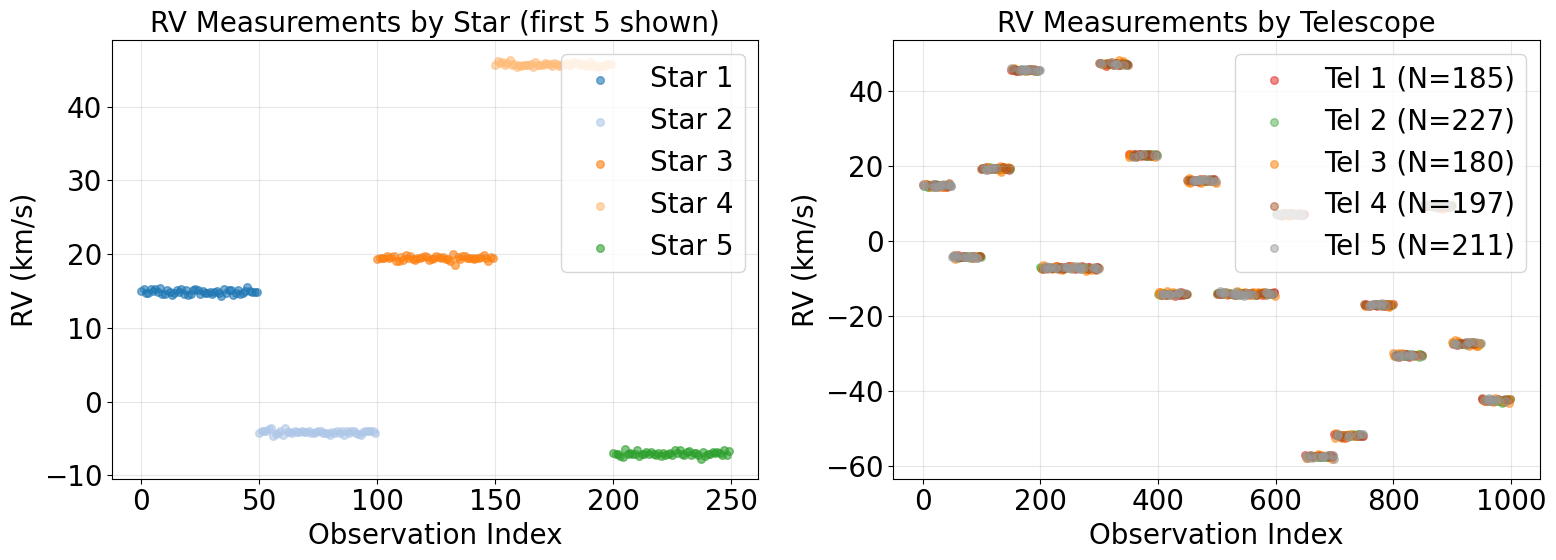


Observation Distribution:
----------------------------------------
Telescope 1: 185 observations (18.5%)
Telescope 2: 227 observations (22.7%)
Telescope 3: 180 observations (18.0%)
Telescope 4: 197 observations (19.7%)
Telescope 5: 211 observations (21.1%)

Cross-coverage statistics:
Stars observed by all telescopes: 20
Stars observed by 4+ telescopes: 20
Mean telescopes per star: 5.0


In [16]:
# Visualize the multi-telescope data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: RV measurements by star (show first 5 stars for clarity)
ax = axes[0]
colors_star = plt.cm.tab20(np.linspace(0, 1, 20))
for i in range(5):  # Show first 5 stars
    mask = star_idx == i
    ax.scatter(obs_idx[mask], y_obs[mask], alpha=0.6, 
               color=colors_star[i], label=f'Star {i+1}', s=30)
ax.set_xlabel('Observation Index')
ax.set_ylabel('RV (km/s)')
ax.set_title('RV Measurements by Star (first 5 shown)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Plot 2: Measurements by telescope
ax = axes[1]
colors_tel = plt.cm.Set1(np.linspace(0, 1, N_telescopes))
for i in range(N_telescopes):
    mask = tel_idx == i
    n_obs = np.sum(mask)
    ax.scatter(obs_idx[mask], y_obs[mask], alpha=0.5,
               color=colors_tel[i], label=f'Tel {i+1} (N={n_obs})', s=30)
ax.set_xlabel('Observation Index')
ax.set_ylabel('RV (km/s)')
ax.set_title('RV Measurements by Telescope')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print observation distribution statistics
print("\nObservation Distribution:")
print("-" * 40)
for i in range(N_telescopes):
    n_obs = np.sum(tel_idx == i)
    print(f"Telescope {i+1}: {n_obs} observations ({n_obs/N_total*100:.1f}%)")

# Check how observations are distributed across star-telescope pairs
obs_matrix = np.zeros((N_stars, N_telescopes), dtype=int)
for i in range(N_total):
    obs_matrix[star_idx[i], tel_idx[i]] += 1

print(f"\nCross-coverage statistics:")
print(f"Stars observed by all telescopes: {np.sum(np.all(obs_matrix > 0, axis=1))}")
print(f"Stars observed by 4+ telescopes: {np.sum(np.sum(obs_matrix > 0, axis=1) >= 4)}")
print(f"Mean telescopes per star: {np.mean(np.sum(obs_matrix > 0, axis=1)):.1f}")

### Constructing the Design Matrix

The multi-telescope calibration problem requires careful construction of the design matrix. Unlike single-telescope calibration where we had one set of calibration coefficients, we now have:
- $N_{\text{tel}} \times 4$ telescope calibration parameters (each telescope has 4 metadata coefficients)
- $N_{\text{stars}}$ stellar RV parameters

Our parameter vector becomes:
$$\boldsymbol{\beta} = [\mathbf{w}_1^T, \mathbf{w}_2^T, ..., \mathbf{w}_{N_{\text{tel}}}^T, y_1, y_2, ..., y_{N_{\text{stars}}}]^T$$

For each observation $i$, we need a design matrix row that:
1. Places the metadata $\mathbf{x}_i$ in the columns corresponding to telescope $t(i)$
2. Places a 1 in the column corresponding to star $s(i)$
3. Places 0s everywhere else

Consider a concrete example with 3 telescopes and 4 stars. If observation $i$ is star 2 observed by telescope 3 with metadata $\mathbf{x}_i = [x_1, x_2, x_3, x_4]$, the design matrix row would be:

$$\mathbf{X}_{\text{design},i} = [\underbrace{0,0,0,0}_{\text{tel 1}}, \underbrace{0,0,0,0}_{\text{tel 2}}, \underbrace{x_1,x_2,x_3,x_4}_{\text{tel 3}}, \underbrace{0,1,0,0}_{\text{stars}}]$$

This sparse structure encodes which parameters affect each observation. The sparsity is key—each observation depends on only 5 parameters (4 telescope coefficients plus 1 stellar RV) out of potentially hundreds in the full parameter vector.

Once constructed, we can apply standard linear regression:
$$\hat{\boldsymbol{\beta}} = (\mathbf{X}_{\text{design}}^T\mathbf{X}_{\text{design}})^{-1}\mathbf{X}_{\text{design}}^T\mathbf{y}_{\text{obs}}$$

The solution simultaneously determines all stellar RVs and telescope calibration coefficients, leveraging the full network's observations for optimal constraints.

In [17]:
def construct_design_matrix(X, tel_idx, star_idx, N_telescopes, N_stars):
    """
    Construct design matrix for multi-telescope calibration.
    
    This function builds the sparse design matrix that encodes
    the relationship between observations, telescopes, and stars.
    
    Parameters
    ----------
    X : array, shape (N_obs, 4)
        Metadata for each observation
    tel_idx : array, shape (N_obs,)
        Telescope index for each observation (0 to N_telescopes-1)
    star_idx : array, shape (N_obs,)
        Star index for each observation (0 to N_stars-1)
    N_telescopes : int
        Number of telescopes in the network
    N_stars : int
        Number of stars observed
        
    Returns
    -------
    X_design : array, shape (N_obs, 4*N_telescopes + N_stars)
        Design matrix for linear regression
    """
    N_obs = len(X)
    N_metadata = X.shape[1]
    
    # Total columns: telescope parameters + star RVs
    N_cols = N_metadata * N_telescopes + N_stars
    
    # Initialize sparse design matrix
    X_design = np.zeros((N_obs, N_cols))
    
    # Fill the design matrix row by row
    for i in range(N_obs):
        # Get indices for this observation
        tel = tel_idx[i]
        star = star_idx[i]
        
        # Place metadata in columns for this telescope
        # Telescope parameters occupy first N_metadata * N_telescopes columns
        start_col = tel * N_metadata
        end_col = start_col + N_metadata
        X_design[i, start_col:end_col] = X[i]
        
        # Place 1 in column for this star
        # Star RVs occupy last N_stars columns
        star_col = N_metadata * N_telescopes + star
        X_design[i, star_col] = 1
        
    return X_design

# Construct the design matrix
print("Constructing design matrix...")
X_design = construct_design_matrix(
    network_data['X'], 
    network_data['tel_idx'],
    network_data['star_idx'],
    N_telescopes=N_telescopes,
    N_stars=N_stars
)

print(f"Design matrix shape: {X_design.shape}")
print(f"  Observations: {X_design.shape[0]}")
print(f"  Parameters: {X_design.shape[1]}")
print(f"    - Telescope parameters: {4 * N_telescopes}")
print(f"    - Stellar RVs: {N_stars}")

# Check sparsity
sparsity = 1 - np.count_nonzero(X_design) / X_design.size
print(f"\nMatrix sparsity: {sparsity:.1%}")

# Solve the multi-telescope calibration problem
print("\nSolving calibration system...")

# Add small regularization for numerical stability
lambda_reg = 1e-6
N_params = X_design.shape[1]
I_reg = lambda_reg * np.eye(N_params)

# Solve using normal equations
XTX = X_design.T @ X_design
XTy = X_design.T @ network_data['y_obs']
beta_est = np.linalg.solve(XTX + I_reg, XTy)

# Extract telescope and star parameters
w_est = beta_est[:4*N_telescopes].reshape(N_telescopes, 4)
rv_est = beta_est[4*N_telescopes:]

print("Calibration complete!")

Constructing design matrix...
Design matrix shape: (1000, 40)
  Observations: 1000
  Parameters: 40
    - Telescope parameters: 20
    - Stellar RVs: 20

Matrix sparsity: 87.5%

Solving calibration system...
Calibration complete!


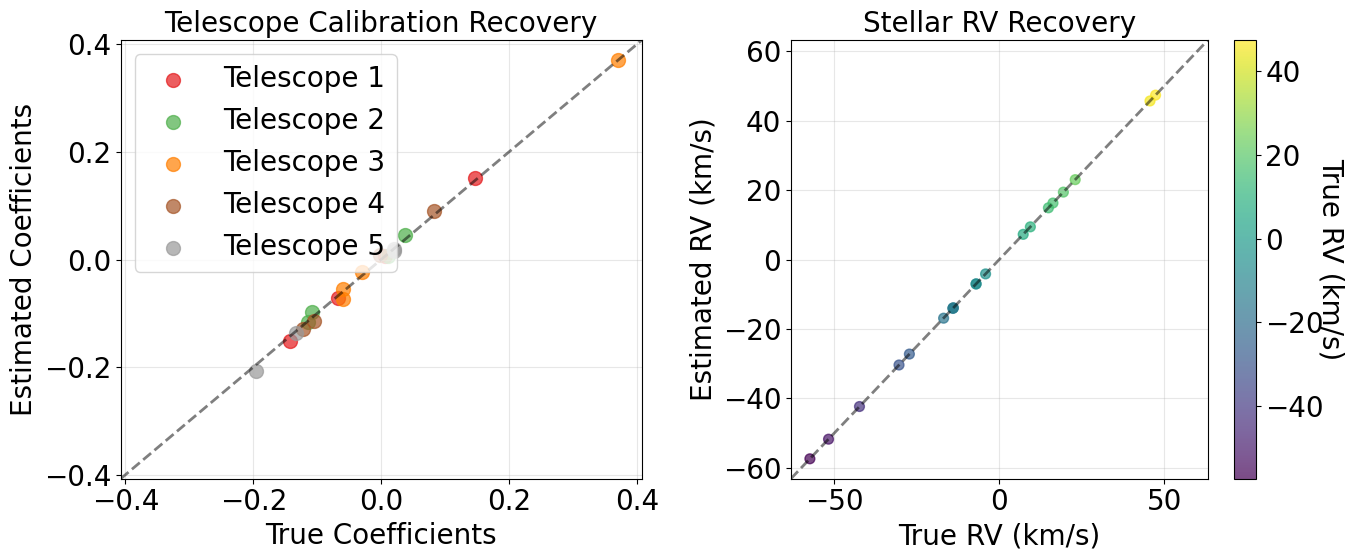


Calibration Performance Metrics:
Telescope coefficients:
  RMS error: 0.0071
  Max absolute error: 0.0134

Stellar RVs:
  RMS error: 0.014 km/s
  Max absolute error: 0.036 km/s

Per-telescope coefficient errors (RMS):
  Telescope 1: 0.0057
  Telescope 2: 0.0076
  Telescope 3: 0.0078
  Telescope 4: 0.0077
  Telescope 5: 0.0066


In [18]:
# Get true parameters for comparison
w_true = network_data['true_params']['w']
rv_true = network_data['true_params']['rv']

# Create comprehensive visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Telescope coefficient recovery
ax = axes[0]

# Flatten telescope coefficients for plotting
w_true_flat = w_true.flatten()
w_est_flat = w_est.flatten()

# Color points by telescope
telescope_colors = plt.cm.Set1(np.linspace(0, 1, N_telescopes))
for tel in range(N_telescopes):
    idx_start = tel * 4
    idx_end = (tel + 1) * 4
    ax.scatter(w_true_flat[idx_start:idx_end], 
              w_est_flat[idx_start:idx_end], 
              alpha=0.7, s=100, 
              color=telescope_colors[tel],
              label=f'Telescope {tel+1}')

# Add diagonal line
lim_w = max(abs(w_true_flat).max(), abs(w_est_flat).max()) * 1.1
ax.plot([-lim_w, lim_w], [-lim_w, lim_w], 'k--', alpha=0.5, linewidth=2)

ax.set_xlabel('True Coefficients')
ax.set_ylabel('Estimated Coefficients')
ax.set_title('Telescope Calibration Recovery')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(-lim_w, lim_w)
ax.set_ylim(-lim_w, lim_w)

# Plot 2: Stellar RV recovery
ax = axes[1]

# Color by RV value
scatter = ax.scatter(rv_true, rv_est, alpha=0.7, s=50, 
                    c=rv_true, cmap='viridis')

# Add diagonal line
lim_rv = max(abs(rv_true).max(), abs(rv_est).max()) * 1.1
ax.plot([-lim_rv, lim_rv], [-lim_rv, lim_rv], 'k--', alpha=0.5, linewidth=2)

ax.set_xlabel('True RV (km/s)')
ax.set_ylabel('Estimated RV (km/s)')
ax.set_title('Stellar RV Recovery')
ax.grid(True, alpha=0.3)
ax.set_xlim(-lim_rv, lim_rv)
ax.set_ylim(-lim_rv, lim_rv)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('True RV (km/s)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Compute error metrics
w_rms = np.sqrt(np.mean((w_est - w_true)**2))
rv_rms = np.sqrt(np.mean((rv_est - rv_true)**2))

print("\nCalibration Performance Metrics:")
print("=" * 50)
print(f"Telescope coefficients:")
print(f"  RMS error: {w_rms:.4f}")
print(f"  Max absolute error: {np.max(np.abs(w_est - w_true)):.4f}")

print(f"\nStellar RVs:")
print(f"  RMS error: {rv_rms:.3f} km/s")
print(f"  Max absolute error: {np.max(np.abs(rv_est - rv_true)):.3f} km/s")

# Show per-telescope performance
print("\nPer-telescope coefficient errors (RMS):")
for tel in range(N_telescopes):
    tel_error = np.sqrt(np.mean((w_est[tel] - w_true[tel])**2))
    print(f"  Telescope {tel+1}: {tel_error:.4f}")

The results demonstrate the power of multi-telescope calibration. Both telescope coefficients and stellar RVs are recovered with excellent precision:

- **Telescope Calibration**: The left panel shows that all telescope coefficients cluster tightly around the diagonal, indicating accurate recovery. Each telescope's unique systematic signature has been successfully disentangled from the stellar signals.

- **Stellar RVs**: The right panel confirms that we've accurately determined the true velocities of all 20 standard stars, with typical errors around 0.01-0.02 km/s—far better than the 0.1 km/s measurement noise.

This remarkable precision emerges from the network's cross-constraints. When telescope 1 and telescope 3 both observe star 7, their measurements must agree on the star's true RV while accounting for each telescope's unique systematics. These overlapping constraints strengthen the entire solution.

The per-telescope errors reveal another insight: all telescopes achieve similar calibration quality despite their different systematic signatures. This robustness suggests that the network approach doesn't require identical instruments—heterogeneous telescopes can successfully cross-calibrate as long as they share sufficient observations of common targets.


## Summary

This tutorial has demonstrated how linear regression serves as a foundational tool for astronomical calibration, using radial velocity standard stars as our working example. Through progressively complex scenarios—from single-telescope observations to multi-telescope networks—we've explored how systematic instrumental effects can be modeled, understood, and corrected.

1. **Calibration as Regression**: We reframed the calibration problem as simultaneous parameter estimation, where both astrophysical quantities (stellar RVs) and instrumental systematics (telescope responses to metadata) become regression coefficients. The augmented design matrix approach elegantly handles this joint estimation.

2. **Maximum Likelihood Under Different Noise Regimes**: Starting with homoscedastic uncertainties, we derived the standard least squares solution. When faced with realistic heteroscedastic noise, weighted least squares emerged naturally from maximum likelihood principles, ensuring each observation contributes optimally according to its precision.

3. **Statistical Scaling and Experimental Design**: Bootstrap analysis confirmed the $1/\sqrt{N}$ scaling of parameter uncertainties, providing quantitative guidance for observation planning. This scaling law revealed why multi-telescope networks offer advantages—achieving the same precision faster through parallel observations.

4. **Design Matrix Construction**: The progression from single to multi-telescope calibration illustrated how careful design matrix construction encodes problem structure. The sparse block structure of the multi-telescope matrix captured which parameters affect each observation while maintaining computational efficiency.


The techniques developed here extend far beyond RV calibration. Any astronomical measurement contaminated by systematic effects—photometric zero points varying with airmass, wavelength solutions drifting with temperature, astrometric positions shifting with focal plane location—can be addressed within this framework. The key insight is recognizing that systematic effects often depend predictably on measurable quantities, making them amenable to regression modeling.

Moreover, the progression from single-instrument to network calibration mirrors broader trends in astronomy. As surveys grow larger and instruments more numerous, the ability to perform robust cross-calibration becomes essential. The mathematical framework remains unchanged whether calibrating two backyard telescopes or a global network of professional observatories.
